In [1]:
import io
import os
import sys
import csv
import gzip
import time
import multiprocessing
import resource
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import itertools
import collections
sys.path.append('scripts/')
import lcwgSus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None

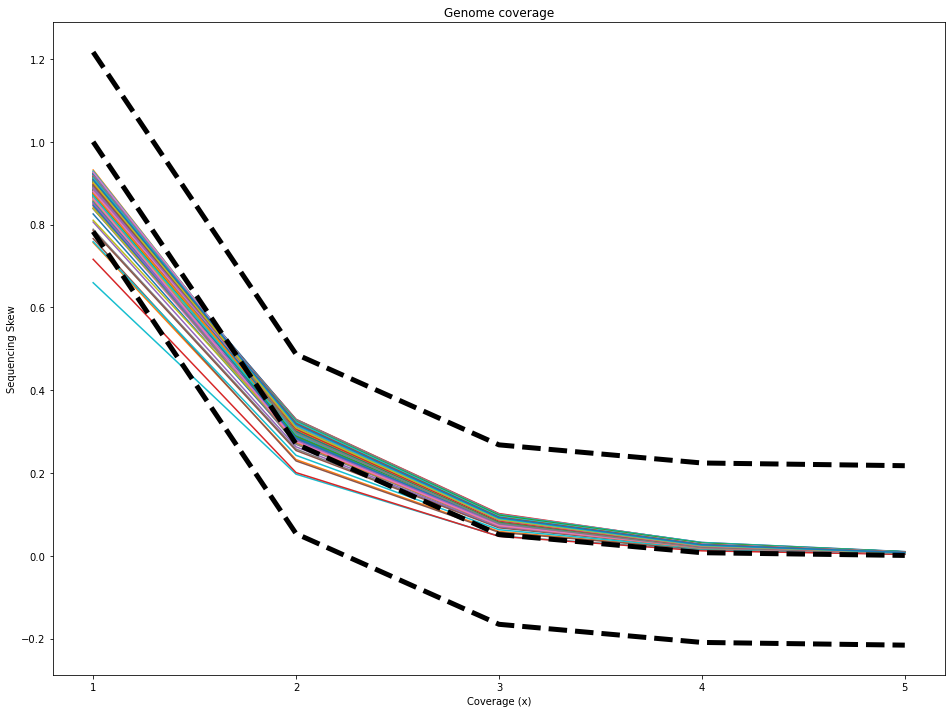

In [3]:
x = pd.read_csv('../samples.tsv', header = None, names = ['Code'])
samples = x['Code'].to_list()
ary_lst = []
for i in samples:
    ary_lst.append(np.loadtxt("../results/coverage/subsampled_bedgraphs/" + i + "_cumsum_ary.txt"))
lcwgSus.plot_sequencing_skew(ary_lst, 0.6, save_fig = True, outdir = '../graphs/') 